<a href="https://colab.research.google.com/github/Ira00/C/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22SML_Final_Project_Image_Colorization_Pretrained_CNN_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Colorization
Before Artificial Intelligence, image colorization was reserved to artists that aimed to give the original colors to a picture. In fact, professional image colorization is currently done by hand in Photoshop. Despite it is a challenging problem due to the multiple image conditions that need to be considered, nowadays, deep learning techniques have achieved promising results in this field.

This project aims to study the Image Colorization problem of the Computer Vision branch and implement a Deep Neural Network that is able to colorize black and white images.

## Tools
The tools utilized for this project include:
- Python 3.7.
- Tensorflow 2.4 with Keras: open-source framework for machine learning and deep learning applications. It was used to preprocess input data, create data pipelines and train models with different Keras layers.
- Datalore: cloud service created by JetBrains that facilitates collaborative work with Jupyter Notebook.
- Various python libraries, such as NumPy and matplotlib.

## Dataset
Regarding the data, two public datasets were used:
- Flickr 30k dataset: a public dataset which contains 30 thousand images in 200x200 resolution. It has become a standard benchmark for image captioning, but because of the variety of images that it contains, this dataset was used for final training and validation of the models \cite{flickr30k}.
- Flickr 8k dataset: a subset of the previous dataset containing 8 thousand images in 200x200 resolution. It was used mostly for initial training of the models to understand the performance of the implemented models \cite{flickr8k}.

## Methodology
First, the data will be collected from the selected dataset and prepared to be provided as an input for a deep learning model. After this, several architectures of Deep Neural Network including Convolutional Neural Networks and Autoencoders will be implemented using a machine learning framework. Finally, an evaluation metric such as Mean Squared Error (MSE) will be selected to compare the implemented models using hyper-tuning.

## References
[1] CIELAB color space.Wikipedia Article:  Advantages paragraph.

[2] Flickr 30k dataset.https://www.kaggle.com/adityajn105/flickr30k.

[3] Flickr  8k  dataset  with  captions.https://www.kaggle.com/kunalgupta2616/flickr-8k-images-with-captions.

[4] tf.data.dataset api.https://www.tensorflow.org/apidocs/python/tf /data/Dataset.

[5] Anwar, S., Tahir, M., Li, C., Mian, A., Khan, F. S., and Muzaffar, A. W.Imagecolorization:  A survey and dataset, 2020.

[6] Chollet, F.Xception:  Deep learning with depthwise separable convolutions.  InProceedings ofthe IEEE conference on computer vision and pattern recognition(2017), pp. 1251–1258.

[7] Lewinson,E.Imagecolorizationusingconvolutionalautoencoders.https://towardsdatascience.com/image-colorization-using-convolutional-autoencoders-fdabc1cb1dbe.

[8]Zhang, R., Isola, P., and Efros, A. A.Colorful image colorization.  InEuropean conferenceon computer vision(2016), Springer, pp. 649–666.

## Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#len(os.listdir('train30000/Images'))

In [ ]:
!unzip drive/MyDrive/train30000.zip

In [ ]:
#!unzip drive/MyDrive/my_train.zip

In [ ]:
# Preprocessing
import os
import pathlib
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Deep Learning
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, Reshape, Input, Flatten

## Data Preprocessing
In order to train the models, the datasets described above had to be preprocessed before being provided to the models. The original color space of the images was the infamous RGB representation, which represents the color from an image using three different channels: Red, Green and Blue. However, this color space does not approximate to the human vision, and previous literature has shown that better results can be achieved by using the [LAB color space](https://towardsdatascience.com/computer-vision-101-working-with-color-images-in-python-7b57381a8a54).

LAB format splits the image in 3 channels:
- L: Lightness of the image on a scale from 0 to 100. This channel represents a grayscale image.
- a: green-red color spectrum. The values range from -128 (green) to 127 (red).
- b: blue-yellow spectrum. The values range from -128 (blue) to 127 (yellow). 

### Third-party Helpers
In order to use convert the images to LAB color space using tensorflow data pipeline, [third-party modules](https://github.com/xahidbuffon/TF_RGB_LAB) that can be compiled to graph were used.

In [ ]:
def preprocess_lab(lab):
    with tf.name_scope('preprocess_lab'):
        L_chan, a_chan, b_chan = tf.unstack(lab, axis=2)
        # L_chan: black and white with input range [0, 100]
        # a_chan/b_chan: color channels with input range ~[-110, 110], not exact
        # [0, 100] => [-1, 1],  ~[-110, 110] => [-1, 1]
        return [L_chan / 50 - 1, a_chan / 110, b_chan / 110]

def deprocess_lab(L_chan, a_chan, b_chan):
    with tf.name_scope('deprocess_lab'):
        #TODO This is axis=3 instead of axis=2 when deprocessing batch of images 
               # ( we process individual images but deprocess batches)
        #return tf.stack([(L_chan + 1) / 2 * 100, a_chan * 110, b_chan * 110], axis=3)
        return tf.stack([(L_chan + 1) / 2 * 100, a_chan * 110, b_chan * 110], axis=2)

def check_image(image):
    assertion = tf.assert_equal(tf.shape(image)[-1], 3, message='image must have 3 color channels')
    with tf.control_dependencies([assertion]):
        image = tf.identity(image)

    if image.get_shape().ndims not in (3, 4):
        raise ValueError('image must be either 3 or 4 dimensions')

    # make the last dimension 3 so that you can unstack the colors
    shape = list(image.get_shape())
    shape[-1] = 3
    image.set_shape(shape)
    return image

def rgb_to_lab(srgb):
    # based on https://github.com/torch/image/blob/9f65c30167b2048ecbe8b7befdc6b2d6d12baee9/generic/image.c
    with tf.name_scope('rgb_to_lab'):
        srgb = check_image(srgb)
        srgb_pixels = tf.reshape(srgb, [-1, 3])
        with tf.name_scope('srgb_to_xyz'):
            linear_mask = tf.cast(srgb_pixels <= 0.04045, dtype=tf.float32)
            exponential_mask = tf.cast(srgb_pixels > 0.04045, dtype=tf.float32)
            rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
            rgb_to_xyz = tf.constant([
                #    X        Y          Z
                [0.412453, 0.212671, 0.019334], # R
                [0.357580, 0.715160, 0.119193], # G
                [0.180423, 0.072169, 0.950227], # B
            ])
            xyz_pixels = tf.matmul(rgb_pixels, rgb_to_xyz)

        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope('xyz_to_cielab'):
            # convert to fx = f(X/Xn), fy = f(Y/Yn), fz = f(Z/Zn)

            # normalize for D65 white point
            xyz_normalized_pixels = tf.multiply(xyz_pixels, [1/0.950456, 1.0, 1/1.088754])

            epsilon = 6/29
            linear_mask = tf.cast(xyz_normalized_pixels <= (epsilon**3), dtype=tf.float32)
            exponential_mask = tf.cast(xyz_normalized_pixels > (epsilon**3), dtype=tf.float32)
            fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4/29) * linear_mask + (xyz_normalized_pixels ** (1/3)) * exponential_mask

            # convert to lab
            fxfyfz_to_lab = tf.constant([
                #  l       a       b
                [  0.0,  500.0,    0.0], # fx
                [116.0, -500.0,  200.0], # fy
                [  0.0,    0.0, -200.0], # fz
            ])
            lab_pixels = tf.matmul(fxfyfz_pixels, fxfyfz_to_lab) + tf.constant([-16.0, 0.0, 0.0])

        return tf.reshape(lab_pixels, tf.shape(srgb))


def lab_to_rgb(lab):
    with tf.name_scope('lab_to_rgb'):
        lab = check_image(lab)
        lab_pixels = tf.reshape(lab, [-1, 3])
        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope('cielab_to_xyz'):
            # convert to fxfyfz
            lab_to_fxfyfz = tf.constant([
                #   fx      fy        fz
                [1/116.0, 1/116.0,  1/116.0], # l
                [1/500.0,     0.0,      0.0], # a
                [    0.0,     0.0, -1/200.0], # b
            ])
            fxfyfz_pixels = tf.matmul(lab_pixels + tf.constant([16.0, 0.0, 0.0]), lab_to_fxfyfz)

            # convert to xyz
            epsilon = 6/29
            linear_mask = tf.cast(fxfyfz_pixels <= epsilon, dtype=tf.float32)
            exponential_mask = tf.cast(fxfyfz_pixels > epsilon, dtype=tf.float32)
            xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4/29)) * linear_mask + (fxfyfz_pixels ** 3) * exponential_mask

            # denormalize for D65 white point
            xyz_pixels = tf.multiply(xyz_pixels, [0.950456, 1.0, 1.088754])

        with tf.name_scope('xyz_to_srgb'):
            xyz_to_rgb = tf.constant([
                #     r           g          b
                [ 3.2404542, -0.9692660,  0.0556434], # x
                [-1.5371385,  1.8760108, -0.2040259], # y
                [-0.4985314,  0.0415560,  1.0572252], # z
            ])
            rgb_pixels = tf.matmul(xyz_pixels, xyz_to_rgb)
            # avoid a slightly negative number messing up the conversion
            rgb_pixels = tf.clip_by_value(rgb_pixels, 0.0, 1.0)
            linear_mask = tf.cast(rgb_pixels <= 0.0031308, dtype=tf.float32)
            exponential_mask = tf.cast(rgb_pixels > 0.0031308, dtype=tf.float32)
            srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + ((rgb_pixels ** (1/2.4) * 1.055) - 0.055) * exponential_mask

        return tf.reshape(srgb_pixels, tf.shape(lab))

### Custom Helpers

In [ ]:
# Size used for input images
img_height = 128
img_width = 128

In [ ]:
@tf.function
def get_image_lab(img_path, height=img_height, width=img_width):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [height, width])
       
    image_lab = rgb_to_lab(img / 255.0)
    # L_chan, a_chan, b_chan = preprocess_lab(image_lab)
    # image_lab = deprocess_lab(L_chan, a_chan, b_chan)
    # image_lab = (image_lab) # + [0, 128, 128]) / [100, 255, 255]

    return image_lab

In [ ]:
@tf.function
def get_l_ab_channels(img_path, height=img_height, width=img_width):
    image_lab = get_image_lab(img_path, height, width)
    
    image_l = tf.expand_dims(image_lab[:,:,0], -1)
    image_ab = image_lab[:,:,1:]

    return image_l, image_ab

In [ ]:
# Explanation of how we plot LAB color space: https://towardsdatascience.com/computer-vision-101-working-with-color-images-in-python-7b57381a8a54
def preview_lab_image(img_path, height=img_height, width=img_width):
    fig, ax = plt.subplots(1, 6, figsize = (18, 30))
    
    image_lab = get_image_lab(img_path, height, width)
    
    original_img = lab_to_rgb(image_lab)
    original_img = tf.image.convert_image_dtype(original_img, dtype=tf.uint8, saturate=True)
    
    ax[0].imshow(original_img) # * [100, 255, 255] - [0, 128, 128])) 
    ax[0].axis('off')
    ax[0].set_title('Original')
    
    ax[1].imshow(image_lab.numpy()) 
    ax[1].axis('off')
    ax[1].set_title('Lab')
    
    #imshow(image_lab[:,:,0], ax=ax[1])
    ax[2].imshow(image_lab[:,:,0].numpy(), cmap='gray') 
    ax[2].axis('off')
    ax[2].set_title('L')

    ax[3].imshow(image_lab[:,:,1].numpy(), cmap='RdYlGn_r') 
    ax[3].axis('off')
    ax[3].set_title('a')

    ax[4].imshow(image_lab[:,:,2].numpy(), cmap='YlGnBu_r') 
    ax[4].axis('off')
    ax[4].set_title('b')
    
    ax[5].imshow(np.concatenate((np.zeros((img_height, img_width, 1)), image_lab[:,:,1:].numpy()), axis=2)) 
    ax[5].axis('off')
    ax[5].set_title('ab')

    plt.show()

### Test with single image

In [ ]:
#print(os.listdir('train30000/Images')[0])

In [ ]:
#preview_lab_image("train30000/Images/144328407.jpg", img_height, img_width)

In [ ]:
#image_channels = get_l_ab_channels("train30000/Images/144328407.jpg", img_height, img_width)
#print(image_channels[0].shape)
#print(image_channels[1].shape)

## Load Dataset
Regarding the data, two public datasets were used:
- Flickr 30k dataset: a public dataset which contains 30 thousand images in 200x200 resolution. It has become a standard benchmark for image captioning, but because of the variety of images that it contains, this dataset was used for final training and validation of the models.
- Flickr 8k dataset: a subset of the previous dataset containing 8 thousand images in 200x200 resolution. It was used mostly for initial training of the models to understand the performance of the implemented models.

### Configuration

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Dataset local path
dataset_path = "train30000/Images/flickr30k_images"
dataset_path = pathlib.Path(dataset_path)
image_count = len(list(dataset_path.glob('*.jpg')))

# Training configuration
validation_split = 0.2
batch_size = 96

In [ ]:
image_count

31783

###  Generate Image Pipelines 

In [ ]:
list_ds = tf.data.Dataset.list_files(str(dataset_path/'*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
val_size = int(image_count * validation_split)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
val_size

6356

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(get_l_ab_channels, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(get_l_ab_channels, num_parallel_calls=AUTOTUNE)

### Boost Data Pipelines
Adjust train and validation sets for better performance. [More info](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
def configure_for_performance(ds, cache_dir):
    ds = ds.cache(cache_dir)
    ds = ds.shuffle(buffer_size=image_count)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [ ]:
train_ds = configure_for_performance(train_ds, './train_ds')
val_ds = configure_for_performance(val_ds, './val_ds')

In [ ]:
print(train_ds.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 2), dtype=tf.float32, name=None))>


In [ ]:
len(os.listdir('train30000/Images/flickr30k_images'))

31783

### Visualize Train Data

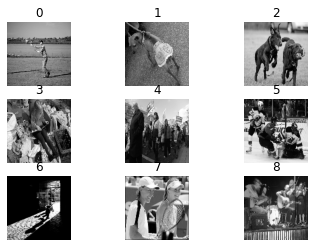

In [ ]:
for image_batch, label_batch in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
    
        plt.imshow(image_batch[i][:,:,0].numpy(), cmap='gray')
        plt.title(i)
        plt.axis("off")

## Models

### CNN Model
The first model trained was inspired by the architecture used in the [Colorful Image Colorization paper](https://arxiv.org/pdf/1603.08511.pdf). The model is build of 8 blocks of convolutional layers, without any pooling layers and using only batch normalization at the end of each block, as the only regularization. The implemented model did not follow exactly the proposed architecture: it does not have a softmax activation layer towards the end of the network and it uses standard Adam optimizer and Mean Square Error loss.

In [ ]:
def get_cnn_model():
    model = tf.keras.Sequential([        
        # CONV 1
        Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
        Conv2D(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
        BatchNormalization(),

        # CONV2
        Conv2D(filters=128, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
        BatchNormalization(),

        #CONV3
        Conv2D(filters=256, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=256, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=256, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
        BatchNormalization(),

        # CONV4
        Conv2D(filters=512, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),

        # CONV5 (padding=2)
        Conv2D(filters=512, kernel_size=3, dilation_rate=2, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, dilation_rate=2, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, dilation_rate=2, strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),

        # CONV6 (padding=2)
        Conv2D(filters=512, kernel_size=3, dilation_rate=2, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, dilation_rate=2, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, dilation_rate=2, strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),

        # CONV7
        Conv2D(filters=512, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=512, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        BatchNormalization(),

        # CONV8
        Conv2DTranspose(filters=256, kernel_size=4, strides=(2,2), padding='same', activation='relu'),
        Conv2D(filters=256, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
        Conv2D(filters=313, kernel_size=1, strides=(1,1), padding='valid'),
        # Softmax(axis=1), This layer was commented from the original model

        # OUTPUT
        Conv2D(filters=2, kernel_size=1, padding='valid', dilation_rate=1, strides=(1,1), use_bias=False),
        UpSampling2D(size=4, interpolation='bilinear'),
    ])
    
    # Show model summary
    model.build()
    print(model.summary())

    return model

In [ ]:
get_cnn_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                        

### Autoencoder Model
The following architecture was adapted from a [blog](https://towardsdatascience.com/image-colorization-using-convolutional-autoencoders-fdabc1cb1dbe) on TowardsDataScience website, where the author was testing different deep learning models for the image colorization using screenshots from Wario Land games. One of the proposed models was an autoencoder that consisted of an encoder part with 4 convolutional layers: the central block of layers, one Flatten, two Dense and one Reshape layers; and the decoder part with 4 convolutional transpose layers. The training was done using RSMprop optimizer and Mean Square Error loss.

In [ ]:
def get_model_autoencoder():
    model = tf.keras.Sequential([
        Input(shape=(img_height, img_width, 1)),

        # ENCODING CONVOLUTIONAL LAYERS
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', strides=2),
        Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', strides=2),
        Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', strides=2),
        Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', strides=2),

        # CENTRAL LAYERS
        Flatten(),
        Dense(256),
        Dense(8*8*256),
        Reshape((8, 8, 256)),

        # DECODING CONVOLUTIONAL TRANSPOSE LAYERS
        Conv2DTranspose(filters=256, kernel_size=3, padding='same', activation='relu', strides=2),
        Conv2DTranspose(filters=128, kernel_size=3, padding='same', activation='relu', strides=2),
        Conv2DTranspose(filters=64, kernel_size=3, padding='same', activation='relu', strides=2),
        Conv2DTranspose(filters=2, kernel_size=3, padding='same', activation='relu', strides=2)
    ])

    # Show model summary
    model.build()
    print(model.summary())
    
    return model

In [ ]:
get_model_autoencoder()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 256)               4194560   
                                                                 
 dense_1 (Dense)             (None, 16384)            

### Combination of CNN and pretrained model
The last implemented architecture was a combination of [Xception pretrained model](https://arxiv.org/pdf/1610.02357.pdf) that acted as an encoder for the input image and five convolutional layers that decode this representation to the expected output. During the training stage, Adam optimizer and Mean Square Error loss were used.

In [ ]:
def get_pretrained_model():
    model = tf.keras.Sequential([
        # Input: Transforming from BW image to RGB
        Input(shape=(img_height, img_width, 1)),
        Conv2D(filters=3, kernel_size=3, padding='same'),

        # Pretrained model
        Xception(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3)),

        # Convolutional layers to transform the third dimension from 2048 to 2 and the size of the images from 4 to 128
        Conv2DTranspose(filters=512, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
        Conv2DTranspose(filters=128, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
        Conv2DTranspose(filters=64, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
        Conv2DTranspose(filters=32, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
        
        # OUTPUT
        Conv2DTranspose(filters=2, kernel_size=3, strides=(2,2), padding='same', activation='relu'),
    ])

    # Freeze layers of pretrained model
    model.layers[1].trainable = False
    
    # Show model summary
    model.build()
    print(model.summary())

    return model

In [ ]:
get_pretrained_model()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 128, 128, 3)       30        
                                                                 
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 8, 8, 512)        9437696   
 ranspose)                                                       
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 128)      589952    
 ranspose)                                                       
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 32, 32, 64)       73792     
 ranspose)                                             

## Train Stage

### Checkpoint
Helper callback to save the best model during training based on validation accuracy. [More Info](https://lambdalabs.com/blog/tensorflow-2-0-tutorial-03-saving-checkpoints/)

In [ ]:
outputFolder = 'model'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
    
filepath = outputFolder + "/model-mse-nosotfmax-{val_accuracy:.3f}.hdf5" # Add {epoch:02d}- to not save only the best

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_accuracy', verbose=0,
    save_best_only=True, save_weights_only=False,
    save_frequency=1)

### Helper Methods

In [ ]:
def plot_training(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Training

In [ ]:
model = get_cnn_model()
model.compile(optimizer='RMSProp', loss='mse', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 128, 128, 64)      640       
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_11 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (None, 64, 64, 128)       73856     
                                                                 
 conv2d_34 (Conv2D)          (None, 32, 32, 128)       147584    
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                     

In [ ]:
#model.load_weights("drive/MyDrive/3epoch.h5")

In [ ]:
TRAIN_STEPS_PER_EPOCH = image_count*batch_size
# to ensure that there are enough images for training bahch
#VAL_STEPS_PER_EPOCH = np.ceil((image_count*0.2/batch_size)-1)

In [ ]:
val_size

6356

In [ ]:
model_info = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=25,
  initial_epoch=0,
  callbacks=[checkpoint_callback] 
)

Epoch 1/10
  2/265 [..............................] - ETA: 9:33:06 - loss: 1083.6663 - accuracy: 0.5135

KeyboardInterrupt: ignored

In [ ]:
image_count

In [ ]:
plot_training(model_info)

In [ ]:
model.save_weights("drive/MyDrive/model30.h5")

## Test Stage

In [ ]:
best_model_weights_path = "drive/MyDrive/cnn_model_last.h5"

In [ ]:
best_model = get_cnn_model()
best_model.load_weights(best_model_weights_path)

### Validation Set
Take one batch of validation set and print predicted image at the left compared to original image at the right.

In [ ]:
a = val_ds.take(1)

In [ ]:
plt.figure(figsize=(10, 10))

for image_batch, label_batch in a:
    predictions = best_model.predict(image_batch,  verbose=1)
    
    for i in range(0, 8, 2):        
        predicted_img = np.concatenate((image_batch[i], predictions[i]), axis=2)
        predicted_img = lab_to_rgb(predicted_img).numpy()
        
        original_img = np.concatenate((image_batch[i], label_batch[i]), axis=2)
        original_img = lab_to_rgb(original_img).numpy()
        
        plt.subplot(4, 2, i + 1)
        plt.imshow(predicted_img)
        plt.title(i)
        plt.axis("off")
        
        plt.subplot(4, 2, i + 2)        
        plt.imshow(original_img)
        plt.title(i)
        plt.axis("off")

## Convert custom pictures
Below are samples with pictures taken from Google.

In [ ]:
def predict_and_show(image_path):
  image_to_predict_lab = get_l_ab_channels(image_path)

  # Use only L channel (grayscale) to predict
  image_to_predict = tf.expand_dims(image_to_predict_lab[0], 0)

  # Predict
  prediction = best_model.predict(image_to_predict,  verbose=1)[0]

  original_img = np.concatenate((image_to_predict_lab[0], image_to_predict_lab[1]), axis=2)
  original_img = lab_to_rgb(original_img).numpy()

  predicted_img = np.concatenate((image_to_predict[0], prediction), axis=2)
  predicted_img = lab_to_rgb(predicted_img).numpy()

  plt.figure(figsize=(10, 10))

  plt.subplot(1, 2, 1)        
  plt.imshow(original_img)
  plt.title("Original")
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.imshow(predicted_img)
  plt.title("Predicted")
  plt.axis("off")

In [ ]:
predict_and_show("mona.jpeg")

In [ ]:
predict_and_show("test2.jpeg")